## Import Environment

In [1]:
# Install specific libraries
! pip install transformers
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay as plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [3]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Directory
%cd /content/drive/MyDrive/Colab\ Notebooks/263\ Final\ Project

/content/drive/MyDrive/Colab Notebooks/263 Final Project


## Load Dataset

In [5]:
data = pd.read_csv("full_dataset_with_text.csv")

In [6]:
data = data.dropna(axis=0, how='any')

In [7]:
data.head()

,Unnamed: 0,title,text,subject,date,Target,label,cleaned_title,cleaned_text
0,0,"Trump’s Favorability Rating Hits Historic, Re...",Americans are waking up. After being promised ...,News,"January 16, 2017",Fake,1,trump favorability rating hit historic record low,american be wake up after be promise trump wou...
1,1,Republican U.S. Senator Cochran postpones retu...,WASHINGTON (Reuters) - Republican Senator Thad...,politicsNews,"October 16, 2017",True,0,republican senator cochran postpones return to...,washington reuters republican senator thad coc...
2,2,NO TOILET PAPER?! SOCIALISM IS IN ITS FINAL ST...,Socialism doesn t work but I guess Venezuela d...,politics,"Apr 6, 2015",Fake,1,no toilet paper socialism be in it final stage...,socialism doesn work but guess venezuela didn ...
3,3,Snowflake Alert: Kellyanne Conway Says Anders...,White House counselor Kellyanne Conway is offe...,News,"May 11, 2017",Fake,1,snowflake alert kellyanne conway say anderson ...,white house counselor kellyanne conway be offe...
4,4,Trump signs memo directing Pentagon to impleme...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"August 25, 2017",True,0,trump sign memo direct pentagon to implement t...,washington reuters president donald trump sign...


([<matplotlib.patches.Wedge at 0x7f85cdd5e530>,
 [Text(-1.1986358762041145, -0.05720171567702159, 'Fake'),
  Text(1.198635870848498, 0.05720182790141112, 'True')],
 [Text(-0.6992042611190668, -0.03336766747826259, '51.5%'),
  Text(0.6992042579949572, 0.03336773294248982, '48.5%')])

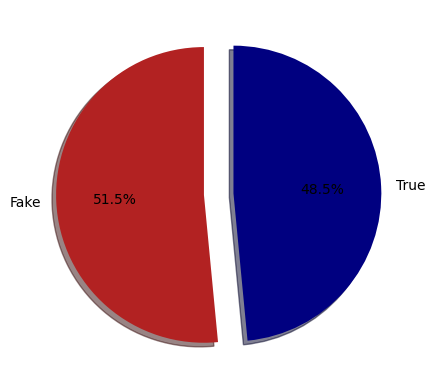

In [8]:
# Display data balance
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [9]:
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['cleaned_text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [10]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Prepare Input Data

Text(0, 0.5, 'Number of texts')

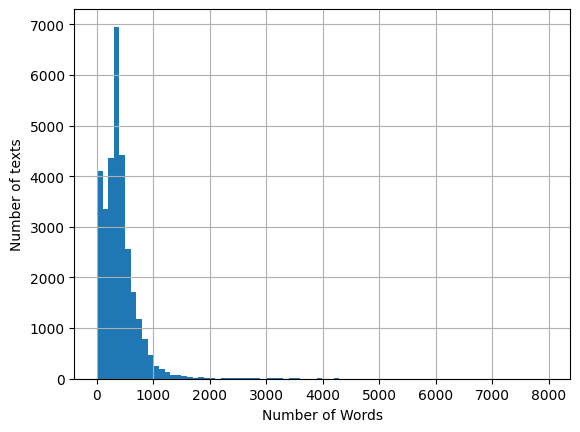

In [11]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 80)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [12]:
# Mean sentence length
np.mean(seq_len)

400.3863717214838

In [13]:
# length 500 covers most of the sentences
MAX_LENGHT = 500

# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

### Use GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda', index=0)

In [16]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids']).to(device)
train_mask = torch.tensor(tokens_train['attention_mask']).to(device)
train_y = torch.tensor(train_labels.tolist()).to(device)

val_seq = torch.tensor(tokens_val['input_ids']).to(device)
val_mask = torch.tensor(tokens_val['attention_mask']).to(device)
val_y = torch.tensor(val_labels.tolist()).to(device)

test_seq = torch.tensor(tokens_test['input_ids']).to(device)
test_mask = torch.tensor(tokens_test['attention_mask']).to(device)
test_y = torch.tensor(test_labels.tolist()).to(device)

# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32  # define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)  # fit into tensors
train_sampler = RandomSampler(train_data)  # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# dataLoader for train set

val_data = TensorDataset(val_seq, val_mask, val_y)  # wrap tensors
val_sampler = SequentialSampler(val_data)  # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# dataLoader for validation set


In [17]:
print("Shape of sent_id (train_seq): ", train_seq.size())
print("Shape of mask (train_mask): ", train_mask.size())

Shape of sent_id (train_seq):  torch.Size([30921, 500])
Shape of mask (train_mask):  torch.Size([30921, 500])


### Freeze Layers

In [18]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [51]:
# We're defining a class called BERT_Arch that inherits from PyTorch's nn.Module class
class BERT_Arch(nn.Module):
    # The constructor method. It takes a pre-trained BERT model as argument
    def __init__(self, bert):
      # Calls the parent class constructor
      super(BERT_Arch, self).__init__()
      
      # Assign the pre-trained BERT model to the class attribute
      self.bert = bert
      
      # Defines a dropout layer with a dropout probability of 0.3, to reduce overfitting
      self.dropout = nn.Dropout(0.3)   
      
      # Defines an Exponential Linear Unit (ELU) activation function layer
      self.elu =  nn.ELU()   
      
      # First fully connected layer, takes the BERT embedding (size 768) as input and outputs to 512 nodes
      self.fc1 = nn.Linear(768,512)   
      
      # Second fully connected layer, takes 512 inputs (from fc1) and outputs to 2 nodes (for binary classification)
      self.fc2 = nn.Linear(512,2)  
      
      # 1D max pooling layer with a kernel size of 3, stride 1 and padding such that the input and output have the same width
      self.maxpool1d = nn.MaxPool1d(3, stride = 1, padding = (3 - 1) // 2)
      
      # Log Softmax function to convert the output into a probability distribution
      self.softmax = nn.LogSoftmax(dim=1)    
      
    # Define the forward propagation method
    def forward(self, sent_id, mask):
      # Feed the inputs through the BERT model and get the 'pooler_output' (final hidden state of the [CLS] token)
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      
      # Feed the output of BERT into the fully connected layer, then through ELU activation, then MaxPool, then Dropout
      x = self.fc1(cls_hs)
      x = self.elu(x)
      x = self.maxpool1d(x.unsqueeze(1)).squeeze(1) # Maxpool expects a 3D tensor hence unsqueeze and squeeze are used
      x = self.dropout(x)
      
      # Feed the output into the second fully connected layer, then through softmax to get the final output probabilities
      x = self.fc2(x)  
      x = self.softmax(x)  
      
      # Return the final output
      return x

# Instantiate the class with a pre-trained BERT model
model = BERT_Arch(bert)

# Import the AdamW optimizer from the transformers library
from transformers import AdamW

# Define the optimizer, here we use AdamW, which is a version of Adam optimizer with weight decay fix
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)  

# Define the loss function, here we use Negative Log Likelihood Loss (NLLLoss) which is suitable for classification tasks with C classes
cross_entropy  = nn.NLLLoss()

# Define the number of training epochs, i.e., the number of times the whole training data is shown to the model
epochs = 50 


### Define Train & Evaluate Function

In [60]:
# Function to train the model
def train():
  # Set the model to train mode. This is necessary as some layers like Dropout or BatchNorm behave differently in training and evaluation modes
  model.train()

  # Initialize counters for total loss and accuracy
  total_loss, total_accuracy = 0, 0

  # Loop over all batches in the training data loader
  for step,batch in enumerate(train_dataloader):
    # Every 50 steps, print the progress of training 
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Unpack the batch contents and assign them to variables
    batch = [r for r in batch]
    sent_id, mask, labels = batch

    # Move the tensors to the GPU (if available)
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)

    # Zero out any gradients calculated in the previous pass
    model.zero_grad()

    # Move the model to GPU (if available)
    model.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    preds = model(sent_id, mask)

    # Calculate the batch loss
    loss = cross_entropy(preds, labels)

    # Add the batch loss to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Clip gradients to avoid exploding gradients problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update the model parameters
    optimizer.step()

  # Calculate the average loss over all the batches
  avg_loss = total_loss / len(train_dataloader)

  # Return the average loss
  return avg_loss

# Function to evaluate the model
def evaluate():
  print("\nEvaluating...")

  # Set the model to evaluation mode
  model.eval()

  # Initialize counters for total loss and accuracy
  total_loss, total_accuracy = 0, 0

  # Loop over all batches in the validation data loader
  for step,batch in enumerate(val_dataloader):
    # Every 50 steps, print the progress of validation
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Unpack the batch contents and assign them to variables
    batch = [t for t in batch]
    sent_id, mask, labels = batch

    # Move the tensors to the GPU (if available)
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model. Use torch.no_grad() to prevent calculating gradients
    with torch.no_grad():
      preds = model(sent_id, mask)

      # Calculate the batch loss
      loss = cross_entropy(preds,labels)

      # Add the batch loss to the total loss
      total_loss = total_loss + loss.item()

  # Calculate the average loss over all the batches
  avg_loss = total_loss / len(val_dataloader)

  # Return the average loss
  return avg_loss


In [61]:
print(model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

### Model training

In [62]:
# Initialize the best validation loss to infinity. This will be updated with lower losses as we go through the epochs
best_valid_loss = float('inf')

# Empty lists to store the train and validation losses for each epoch
train_losses=[]
valid_losses=[]

# Train the model for 'epochs' times
for epoch in range(epochs):
    # Print the epoch number
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Call the train function to train the model and get the training loss for this epoch
    train_loss = train()
    
    # Call the evaluate function to get the validation loss for this epoch
    valid_loss = evaluate()
    
    # If the validation loss for this epoch is lower than the best validation loss seen so far, update the best validation loss and save the model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c3_new_model_weights.pt')  # Save model weights to a .pt file
    
    # Append the train and validation losses for this epoch to the respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print the training and validation losses for this epoch
    print(f'\nTraining Loss: {train_loss:.4f}')
    print(f'Validation Loss: {valid_loss:.4f}')



 Epoch 1 / 50
  Batch    50  of    967.
  Batch   100  of    967.
  Batch   150  of    967.
  Batch   200  of    967.
  Batch   250  of    967.
  Batch   300  of    967.
  Batch   350  of    967.
  Batch   400  of    967.
  Batch   450  of    967.
  Batch   500  of    967.
  Batch   550  of    967.
  Batch   600  of    967.
  Batch   650  of    967.
  Batch   700  of    967.
  Batch   750  of    967.
  Batch   800  of    967.
  Batch   850  of    967.
  Batch   900  of    967.
  Batch   950  of    967.

Evaluating...
  Batch    50  of    208.
  Batch   100  of    208.
  Batch   150  of    208.
  Batch   200  of    208.

Training Loss: 0.4615
Validation Loss: 0.4529

 Epoch 2 / 50
  Batch    50  of    967.
  Batch   100  of    967.
  Batch   150  of    967.
  Batch   200  of    967.
  Batch   250  of    967.
  Batch   300  of    967.
  Batch   350  of    967.
  Batch   400  of    967.
  Batch   450  of    967.
  Batch   500  of    967.
  Batch   550  of    967.
  Batch   600  of    967

### Model performance

In [26]:
# load weights of best model
path = 'c2_new_model_weights.pth'
model.load_state_dict(torch.load(path) )

<All keys matched successfully>

In [63]:
batch_size = 32  # Define the batch size for processing the subsets
total_samples = len(test_seq)
num_batches = (total_samples + batch_size - 1) // batch_size  # Calculate the number of batches

with torch.no_grad():
    model.eval()

    preds_list = []  # List to store the predictions for each subset

    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, total_samples)

        subset_seq = test_seq[start_index:end_index]
        subset_mask = test_mask[start_index:end_index]

        subset_seq = subset_seq.to(device)  # Move the subset tensors to the same device as the model
        subset_mask = subset_mask.to(device)
        model.to(device)
        preds = model(subset_seq, subset_mask)
        preds = preds.detach().cpu().numpy()

        preds_list.append(preds)

    preds = np.concatenate(preds_list, axis=0)  # Concatenate the predictions from all subsets

preds = np.argmax(preds, axis=1)
print(classification_report(test_y.cpu(), preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3212
           1       0.98      0.99      0.99      3414

    accuracy                           0.99      6626
   macro avg       0.99      0.99      0.99      6626
weighted avg       0.99      0.99      0.89      6626



## Fake News Predictions

In [64]:
# Select a subset of the data for testing that the model hasn't seen during training
unseen_news_text = [i for i in data["cleaned_text"][400:404]] #Should be 1,1,0,0

# Define the maximum sequence length that the BERT model will accept
MAX_LENGHT = 500

# Use the BERT tokenizer to convert the sentences into tokens, add special tokens, pad and truncate all sentences to the same length, 
# and then map the sequence of tokens to their IDs
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# Move the sequence of input IDs and attention masks to the device where the model is
unseen_seq = torch.tensor(tokens_unseen['input_ids']).to(device)
unseen_mask = torch.tensor(tokens_unseen['attention_mask']).to(device)

# Make sure that the model doesn't update its parameters when making predictions
with torch.no_grad():
  # Move the model to the device (GPU if available)
  model.to(device)
  
  # Make predictions on the unseen data
  preds = model(unseen_seq, unseen_mask)
  
  # Move the predictions to the CPU
  preds = preds.detach().cpu().numpy()

# Convert the model's outputs, which are probabilities, to class labels by choosing the class with the highest probability
preds = np.argmax(preds, axis = 1)

# Display the predictions
preds


array([1, 1, 0, 0])